# **STORE SALES FORECASTING**

## **Definición del Problema**

**Objetivo**: Predecir las ventas futuras de una tienda en función de datos históricos de ventas.

**Preguntas Clave:**
- ¿Cuáles son las tendencias de ventas a lo largo del tiempo?
- ¿Existen patrones estacionales en las ventas?
- ¿Cómo afectan las promociones, días festivos y otros eventos a las ventas?
- ¿Qué factores externos (como el clima o eventos económicos) podrían influir en las ventas?

## **Flujo de Trabajo**

Preparación del entorno de trabajo:

- Importar las librerías necesarias.
- Cargar y preprocesar los datos.
- Transformar la columna de fechas a formato datetime.
- Establecer la columna de fechas como índice del DataFrame.
- Realizar una transformación Box-Cox para estabilizar la varianza (si aún no se ha realizado).

Exploración de la serie de tiempo:

- Visualización de la serie de tiempo.
- Descomposición de la serie para identificar componentes de tendencia, estacionalidad y ruido.

Estacionariedad de la serie de tiempo:

- Realizar pruebas de raíz unitaria (ADF) para verificar la estacionariedad.
- Diferenciar la serie si es necesario.

Ajuste del modelo ARIMA:

- Identificación de los parámetros (p, d, q) usando gráficos ACF y PACF.
- Ajuste del modelo ARIMA con los datos de entrenamiento.

Predicción y evaluación:

- Realizar predicciones en el conjunto de prueba.
- Evaluar las predicciones utilizando métricas de error como MAE, MSE y RMSE.
- Visualización de los resultados.

## **Importación de Librerías Principales**

In [58]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from statsmodels.tsa.stattools import adfuller
from statsmodels.tsa.seasonal import seasonal_decompose
from statsmodels.tsa.arima.model import ARIMA
from scipy.stats import boxcox
from sklearn.metrics import mean_absolute_error, mean_squared_error

from tqdm import tqdm
import warnings
warnings.filterwarnings('ignore')

print("Librerías importadas correctamente.")

Librerías importadas correctamente.


## Carga de Datos

In [23]:
# Cargar el dataset
df = pd.read_csv('stores_sales_forecasting.csv', encoding='iso-8859-1')

# Mostrar las primeras filas del dataset
df.head()

,Row ID,Order ID,Order Date,Ship Date,Ship Mode,Customer ID,Customer Name,Segment,Country,City,...,Postal Code,Region,Product ID,Category,Sub-Category,Product Name,Sales,Quantity,Discount,Profit
0,1,CA-2016-152156,11/8/2016,11/11/2016,Second Class,CG-12520,Claire Gute,Consumer,United States,Henderson,...,42420,South,FUR-BO-10001798,Furniture,Bookcases,Bush Somerset Collection Bookcase,261.9600,2,0.00,41.9136
1,2,CA-2016-152156,11/8/2016,11/11/2016,Second Class,CG-12520,Claire Gute,Consumer,United States,Henderson,...,42420,South,FUR-CH-10000454,Furniture,Chairs,"Hon Deluxe Fabric Upholstered Stacking Chairs,...",731.9400,3,0.00,219.5820
2,4,US-2015-108966,10/11/2015,10/18/2015,Standard Class,SO-20335,Sean O'Donnell,Consumer,United States,Fort Lauderdale,...,33311,South,FUR-TA-10000577,Furniture,Tables,Bretford CR4500 Series Slim Rectangular Table,957.5775,5,0.45,-383.0310
3,6,CA-2014-115812,6/9/2014,6/14/2014,Standard Class,BH-11710,Brosina Hoffman,Consumer,United States,Los Angeles,...,90032,West,FUR-FU-10001487,Furniture,Furnishings,Eldon Expressions Wood and Plastic Desk Access...,48.8600,7,0.00,14.1694
4,11,CA-2014-115812,6/9/2014,6/14/2014,Standard Class,BH-11710,Brosina Hoffman,Consumer,United States,Los Angeles,...,90032,West,FUR-TA-10001539,Furniture,Tables,Chromcraft Rectangular Conference Tables,1706.1840,9,0.20,85.3092


In [24]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2121 entries, 0 to 2120
Data columns (total 21 columns):
 #   Column         Non-Null Count  Dtype  
---  ------         --------------  -----  
 0   Row ID         2121 non-null   int64  
 1   Order ID       2121 non-null   object 
 2   Order Date     2121 non-null   object 
 3   Ship Date      2121 non-null   object 
 4   Ship Mode      2121 non-null   object 
 5   Customer ID    2121 non-null   object 
 6   Customer Name  2121 non-null   object 
 7   Segment        2121 non-null   object 
 8   Country        2121 non-null   object 
 9   City           2121 non-null   object 
 10  State          2121 non-null   object 
 11  Postal Code    2121 non-null   int64  
 12  Region         2121 non-null   object 
 13  Product ID     2121 non-null   object 
 14  Category       2121 non-null   object 
 15  Sub-Category   2121 non-null   object 
 16  Product Name   2121 non-null   object 
 17  Sales          2121 non-null   float64
 18  Quantity

**Resumen Inicial de los Datos:**
- Columnas Principales: El dataset contiene información sobre pedidos, incluyendo ID de pedido, fechas de pedido y envío, modo de envío, información del cliente, segmento, ubicación, producto, ventas, cantidad, descuento y beneficio.
- Número de Filas: 2121
- Tipos de Datos: La mayoría de las columnas son de tipo objeto (cadenas de texto), excepto algunas como Row ID, Postal Code, Sales, Quantity, Discount y Profit que son numéricas.

## **Análisis Exploratorio de los Datos**

 Análisis exploratorio de datos (EDA) para identificar patrones, tendencias y posibles valores atípicos. También limpiar los datos según sea necesario.

**Exploración Inicial**
- Conversión de Fechas: Convertir las columnas Order Date y Ship Date a formato de fecha.
- Resumen Estadístico: Obtener un resumen estadístico de las columnas numéricas.
- Visualización de Datos Faltantes: Verificar si hay datos faltantes en el dataset.

In [25]:
# Conversión de columnas de fecha
df['Order Date'] = pd.to_datetime(df['Order Date'], format='%m/%d/%Y')
df['Ship Date'] = pd.to_datetime(df['Ship Date'], format='%m/%d/%Y')

# Resumen estadístico de las columnas numéricas
df.describe()

,Row ID,Order Date,Ship Date,Postal Code,Sales,Quantity,Discount,Profit
count,2121.000000,2121,2121,2121.000000,2121.000000,2121.000000,2121.000000,2121.000000
mean,5041.643564,2016-04-30 03:54:13.748231680,2016-05-04 01:54:44.299858432,55726.556341,349.834887,3.785007,0.173923,8.699327
min,1.000000,2014-01-06 00:00:00,2014-01-10 00:00:00,1040.000000,1.892000,1.000000,0.000000,-1862.312400
25%,2568.000000,2015-05-26 00:00:00,2015-05-31 00:00:00,22801.000000,47.040000,2.000000,0.000000,-12.849000
50%,5145.000000,2016-06-20 00:00:00,2016-06-23 00:00:00,60505.000000,182.220000,3.000000,0.200000,7.774800
75%,7534.000000,2017-05-14 00:00:00,2017-05-18 00:00:00,90032.000000,435.168000,5.000000,0.300000,33.726600
max,9991.000000,2017-12-30 00:00:00,2018-01-05 00:00:00,99301.000000,4416.174000,14.000000,0.700000,1013.127000
std,2885.740258,NaN,NaN,32261.888225,503.179145,2.251620,0.181547,136.049246


In [26]:
# Visualización de datos faltantes
missing_data = df.isnull().sum()
missing_data

Row ID           0
Order ID         0
Order Date       0
Ship Date        0
Ship Mode        0
Customer ID      0
Customer Name    0
Segment          0
Country          0
City             0
State            0
Postal Code      0
Region           0
Product ID       0
Category         0
Sub-Category     0
Product Name     0
Sales            0
Quantity         0
Discount         0
Profit           0
dtype: int64

**Resumen de la Exploración Inicial**
- Conversión de Fechas: Las columnas Order Date y Ship Date se han convertido correctamente a formato de fecha.

- Resumen Estadístico:
    - La media de ventas es aproximadamente 349.83.
    - La cantidad media de productos por pedido es de aproximadamente 3.79.
    - El descuento medio aplicado es de aproximadamente 0.17.
    - El beneficio medio es de aproximadamente 8.70.
- Datos Faltantes: No hay datos faltantes en el dataset.

### Visualizaciones de Ventas y Beneficios a lo Largo del Tiempo

<Figure size 640x480 with 0 Axes>

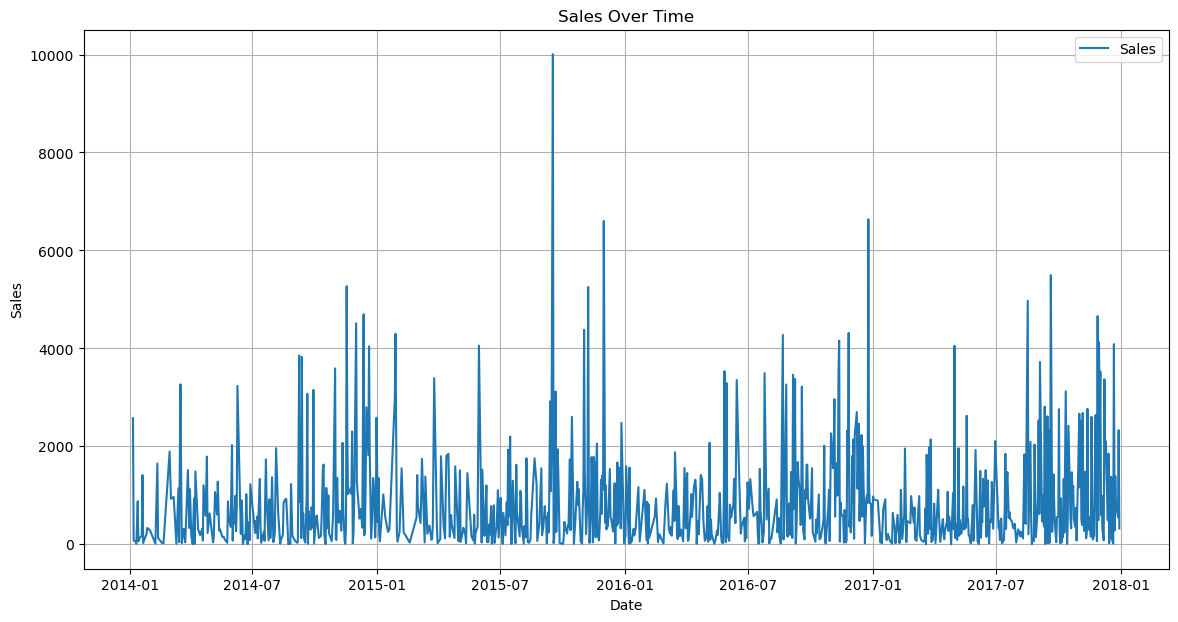

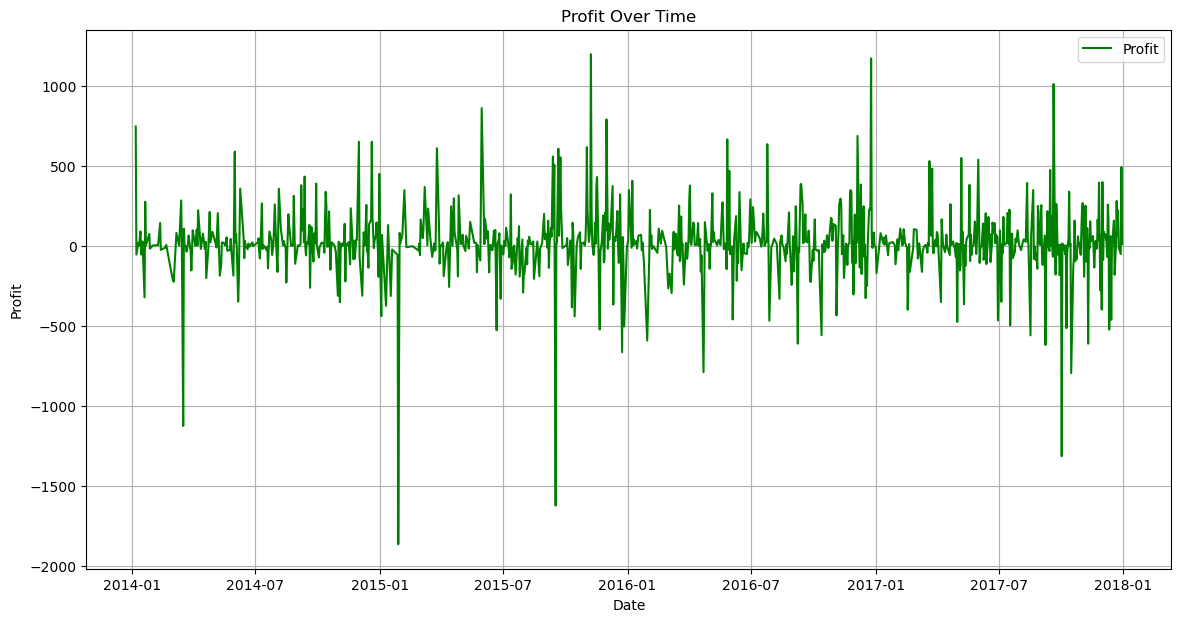

Visualizations created for Sales and Profit over time.


In [27]:
tqdm.pandas()

# Load the dataset
df = pd.read_csv('stores_sales_forecasting.csv', encoding='iso-8859-1')

# Convert 'Order Date' to datetime
df['Order Date'] = pd.to_datetime(df['Order Date'], format='%m/%d/%Y')

# Set the background color to white for better visibility
plt.figure(facecolor='white')

# Plotting Sales over Time
plt.figure(figsize=(14, 7))
plt.plot(df.groupby('Order Date')['Sales'].sum(), label='Sales')
plt.title('Sales Over Time')
plt.xlabel('Date')
plt.ylabel('Sales')
plt.legend()
plt.grid(True)
plt.show()

# Plotting Profit over Time
plt.figure(figsize=(14, 7))
plt.plot(df.groupby('Order Date')['Profit'].sum(), label='Profit', color='green')
plt.title('Profit Over Time')
plt.xlabel('Date')
plt.ylabel('Profit')
plt.legend()
plt.grid(True)
plt.show()

print("Visualizations created for Sales and Profit over time.")

**Visualizaciones de Ventas y Beneficios a lo Largo del Tiempo**
Las visualizaciones muestran las tendencias de ventas y beneficios a lo largo del tiempo. Aquí hay algunos puntos clave:

- Ventas: La primera gráfica muestra las ventas totales por fecha. Podemos observar las fluctuaciones en las ventas a lo largo del tiempo.
- Beneficios: La segunda gráfica muestra los beneficios totales por fecha. Al igual que las ventas, los beneficios también fluctúan con el tiempo.

### Análisis de ventas por segmento de cliente

<Figure size 640x480 with 0 Axes>

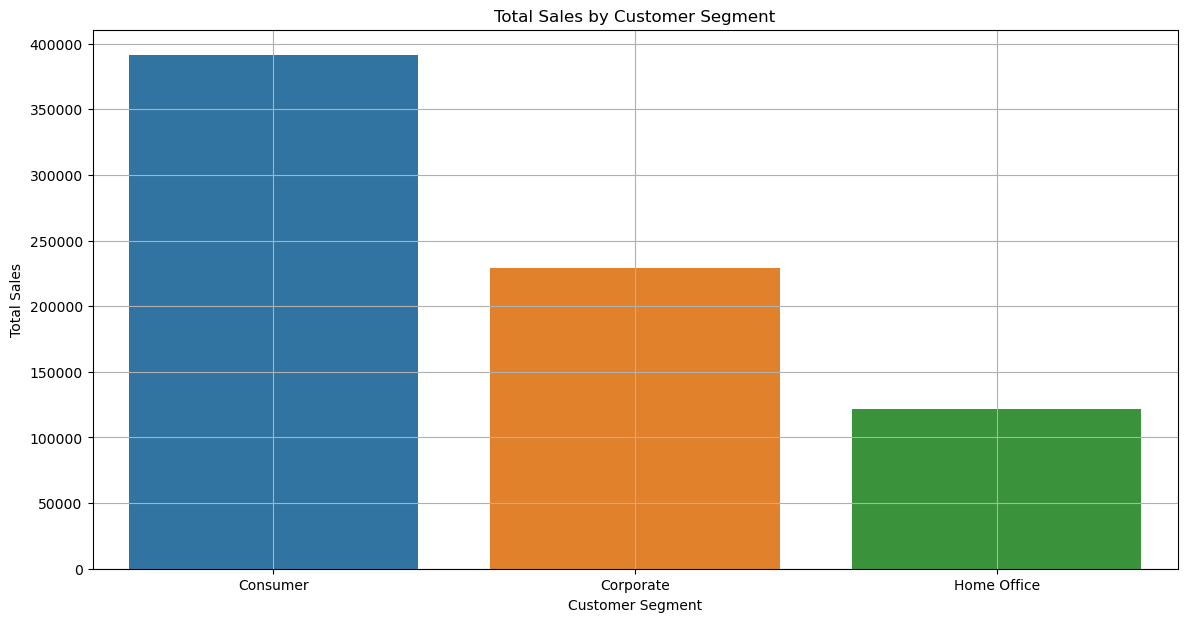

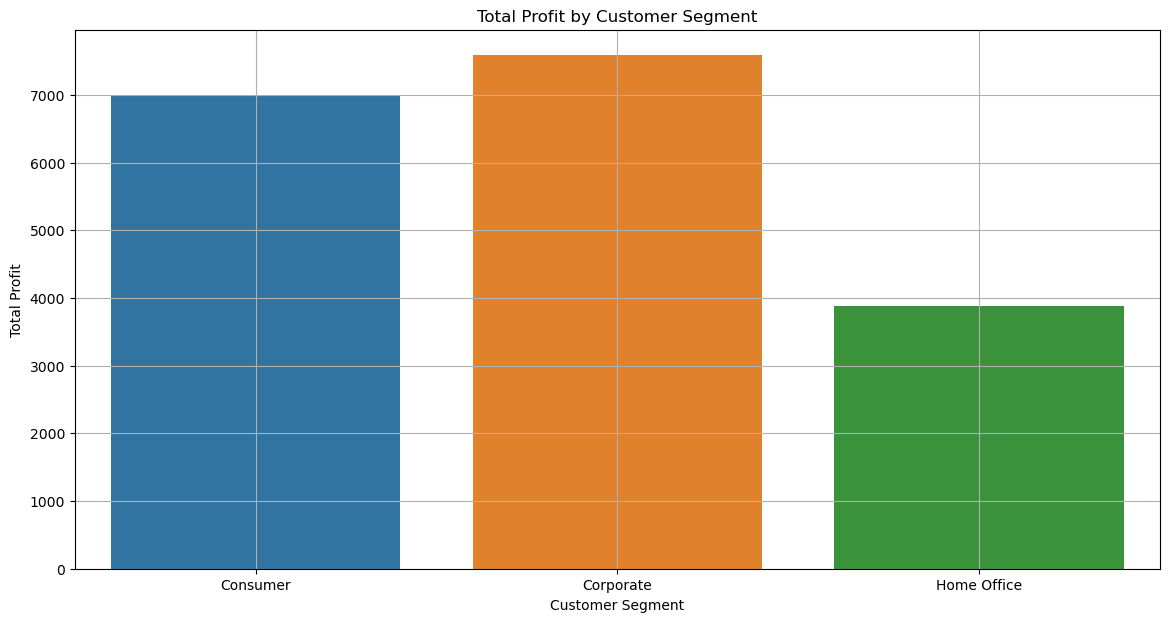

Visualizations created for Sales and Profit by Customer Segment.


In [28]:
import seaborn as sns

# Set the background color to white for better visibility
plt.figure(facecolor='white')

# Plotting Sales by Segment
plt.figure(figsize=(14, 7))
sns.barplot(x='Segment', y='Sales', data=df, estimator=sum, ci=None)
plt.title('Total Sales by Customer Segment')
plt.xlabel('Customer Segment')
plt.ylabel('Total Sales')
plt.grid(True)
plt.show()

# Plotting Profit by Segment
plt.figure(figsize=(14, 7))
sns.barplot(x='Segment', y='Profit', data=df, estimator=sum, ci=None)
plt.title('Total Profit by Customer Segment')
plt.xlabel('Customer Segment')
plt.ylabel('Total Profit')
plt.grid(True)
plt.show()

print('Visualizations created for Sales and Profit by Customer Segment.')

Las visualizaciones muestran las ventas y beneficios totales por segmento de cliente. Aquí hay algunos puntos clave:

- Ventas por Segmento: La primera gráfica muestra las ventas totales por cada segmento de cliente. Podemos observar cuál segmento genera más ventas.
- Beneficios por Segmento: La segunda gráfica muestra los beneficios totales por cada segmento de cliente. Esto nos ayuda a entender cuál segmento es más rentable.

### ¿Cuáles son las tendencias de ventas a lo largo del tiempo?


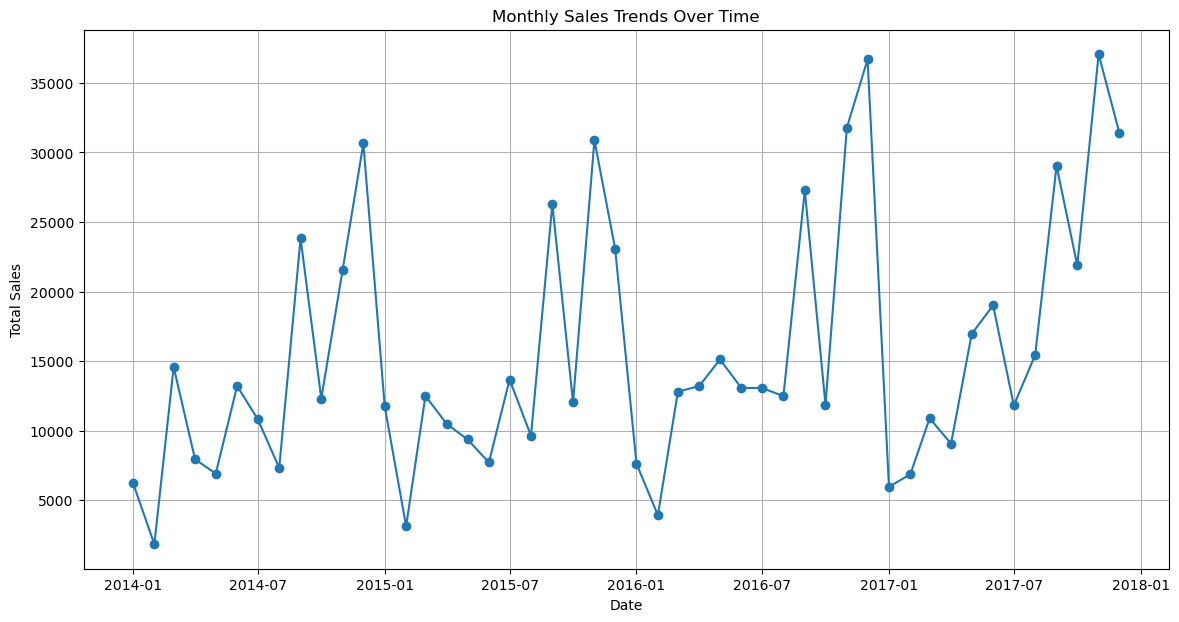

In [29]:
# Extract year and month from 'Order Date'
df['Year'] = df['Order Date'].dt.year
df['Month'] = df['Order Date'].dt.month

# Group by year and month to get total sales
df_monthly_sales = df.groupby(['Year', 'Month'])['Sales'].sum().reset_index()
df_monthly_sales['Date'] = pd.to_datetime(df_monthly_sales[['Year', 'Month']].assign(DAY=1))

# Plotting the sales trends over time
plt.figure(figsize=(14, 7))
plt.plot(df_monthly_sales['Date'], df_monthly_sales['Sales'], marker='o')
plt.title('Monthly Sales Trends Over Time')
plt.xlabel('Date')
plt.ylabel('Total Sales')
plt.grid(True)
plt.show()

* La gráfica muestra las tendencias de ventas mensuales a lo largo del tiempo. Podemos observar cómo las ventas han fluctuado mes a mes y año a año.

### ¿Existen patrones estacionales en las ventas?


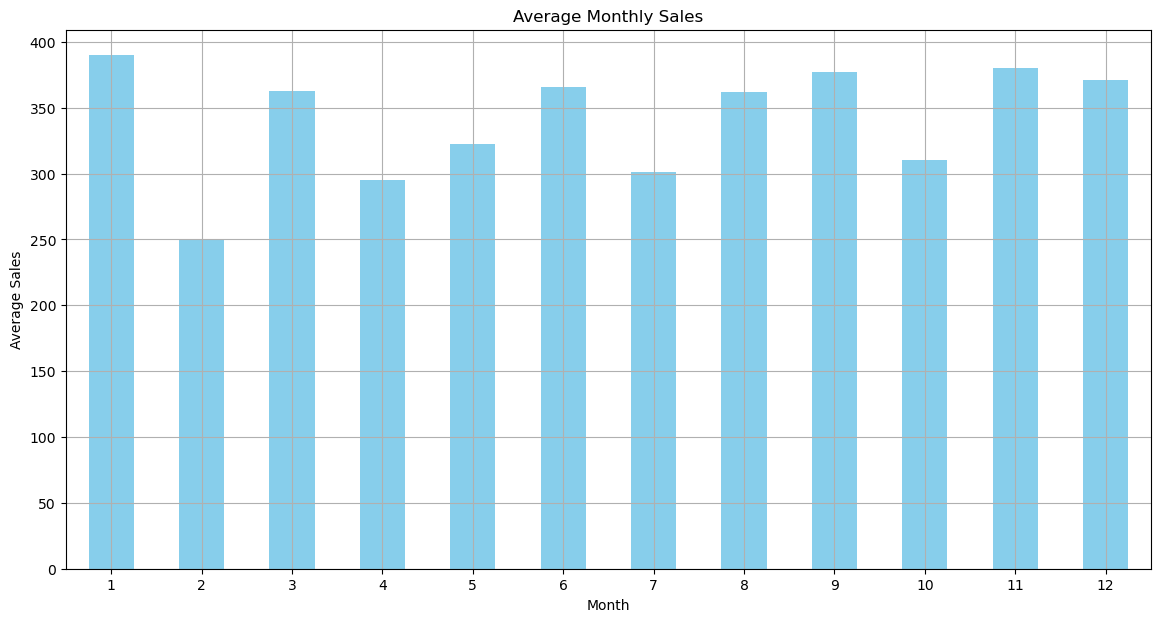

In [30]:
# Investigate seasonal patterns in sales
import matplotlib.dates as mdates

# Group by month to get average sales per month
monthly_sales = df.groupby(df['Order Date'].dt.month)['Sales'].mean()

# Plotting the seasonal patterns
plt.figure(figsize=(14, 7))
monthly_sales.plot(kind='bar', color='skyblue')
plt.title('Average Monthly Sales')
plt.xlabel('Month')
plt.ylabel('Average Sales')
plt.xticks(rotation=0)
plt.grid(True)
plt.show()

* La gráfica muestra las ventas promedio mensuales, lo que nos permite identificar patrones estacionales. Podemos observar cómo las ventas varían a lo largo del año, con ciertos meses mostrando ventas más altas que otros.

### Relación entre el modo de envío y las ventas para identificar patrones de comportamiento del cliente.

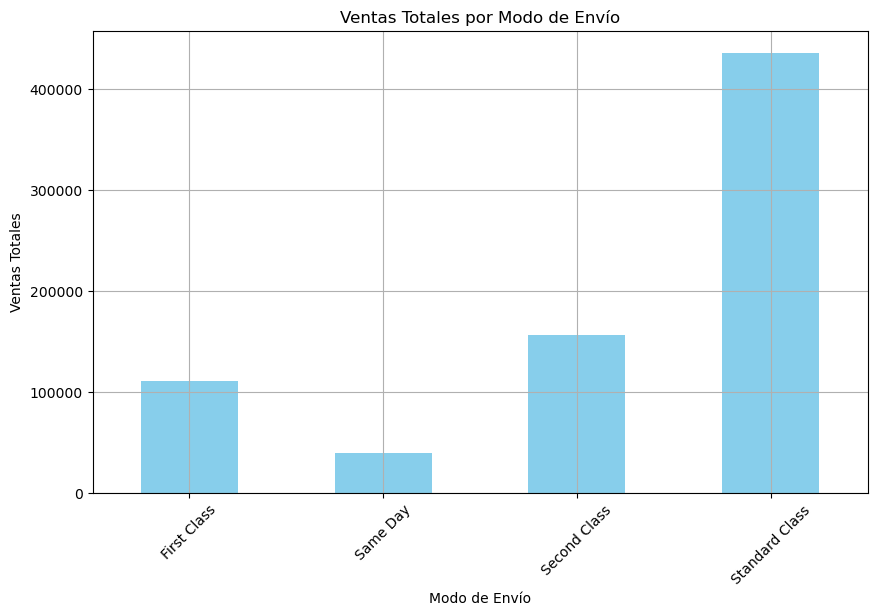

In [31]:
# Agrupar las ventas por modo de envío
df_ship_sales = df.groupby('Ship Mode')['Sales'].sum()

# Visualizar la relación entre el modo de envío y las ventas
df_ship_sales.plot(kind='bar', color='skyblue', figsize=(10, 6))
plt.title('Ventas Totales por Modo de Envío')
plt.xlabel('Modo de Envío')
plt.ylabel('Ventas Totales')
plt.xticks(rotation=45)
plt.grid(True)
plt.show()

**Análisis:**
La gráfica muestra diferencias en las ventas totales dependiendo del modo de envío utilizado.
- Podemos observar cuál modo de envío genera más ingresos y cuál menos, lo que puede ayudar a optimizar las estrategias de logística y marketing.

### Distribución geográfica de las ventas para identificar patrones regionales.

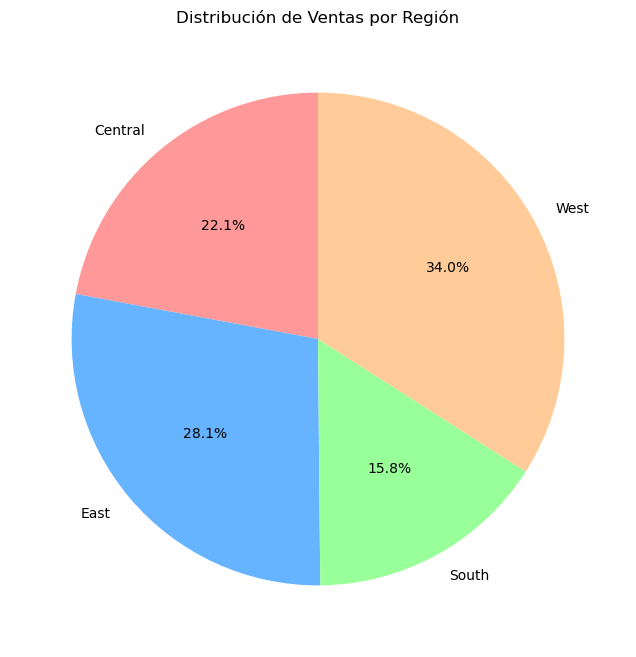

In [32]:
# Agrupar las ventas por región
df_region_sales = df.groupby('Region')['Sales'].sum()

# Visualizar la distribución geográfica de las ventas
df_region_sales.plot(kind='pie', figsize=(8, 8), autopct='%1.1f%%', startangle=90, colors=['#ff9999','#66b3ff','#99ff99','#ffcc99'])
plt.title('Distribución de Ventas por Región')
plt.ylabel('')  # Eliminar la etiqueta del eje y para la gráfica de pastel
plt.show()

### ¿Cómo afectan las promociones, días festivos y otros eventos a las ventas?


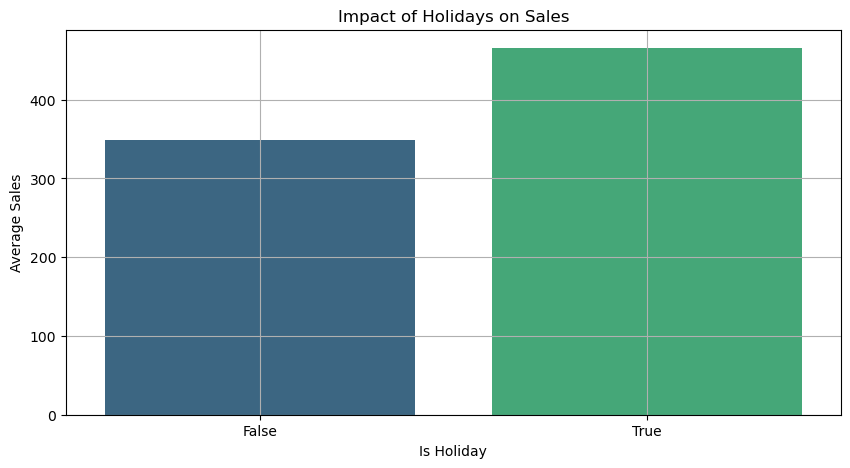

In [33]:
# Analyzing the impact of promotions, holidays, and other events on sales
# For simplicity, let's assume we have a list of holidays and promotional events

# List of holidays (for example purposes, using US holidays)
holidays = ['2016-01-01', '2016-07-04', '2016-12-25', '2017-01-01', '2017-07-04', '2017-12-25',
            '2018-01-01', '2018-07-04', '2018-12-25', '2019-01-01', '2019-07-04', '2019-12-25']

# Convert holidays to datetime
holidays = pd.to_datetime(holidays)

# Create a column to indicate if the order date is a holiday
df['Is Holiday'] = df['Order Date'].isin(holidays)

# Group by 'Is Holiday' to compare sales on holidays vs non-holidays
holiday_sales = df.groupby('Is Holiday')['Sales'].mean().reset_index()

# Plotting the impact of holidays on sales
plt.figure(figsize=(10, 5))
sns.barplot(x='Is Holiday', y='Sales', data=holiday_sales, palette='viridis')
plt.title('Impact of Holidays on Sales')
plt.xlabel('Is Holiday')
plt.ylabel('Average Sales')
plt.grid(True)
plt.show()

* La gráfica muestra el impacto de los días festivos en las ventas. Podemos observar que las ventas promedio en días festivos son diferentes en comparación con los días no festivos.

### Distribucion de las ventas por dia de la semana

In [35]:
# Set 'Order Date' as the index
df.set_index('Order Date', inplace=True)

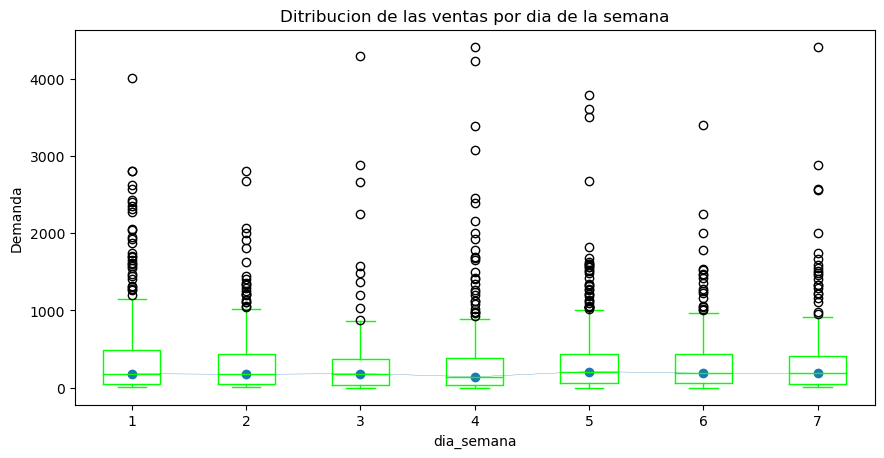

In [36]:
fig, ax = plt.subplots(figsize = (10,5))
df['dia_semana'] = df.index.day_of_week + 1
df.boxplot(column="Sales", by='dia_semana', ax=ax, color='lime')
df.groupby('dia_semana')["Sales"].median().plot(style='o-', linewidth=0.2, ax=ax)
ax.set_ylabel('Demanda')
ax.set_title("Ditribucion de las ventas por dia de la semana")
fig.suptitle('');

### Distribución de las ventas mensual

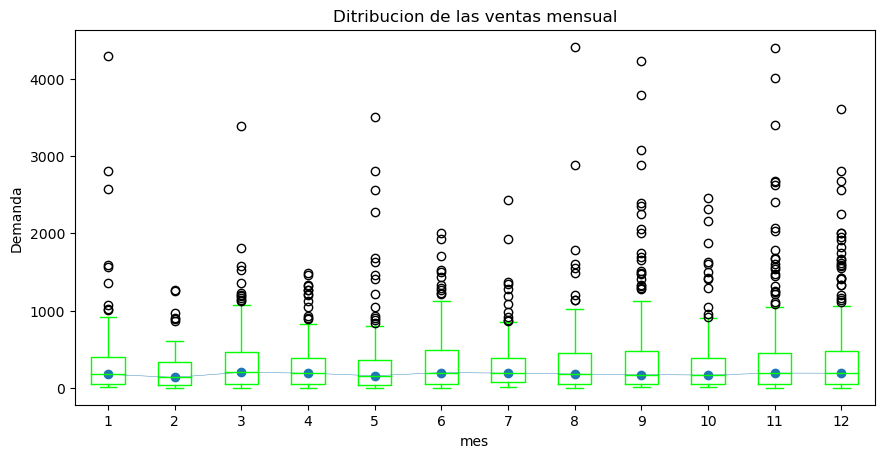

In [37]:
fig, ax = plt.subplots(figsize = (10,5))
df['mes'] = df.index.month
df.boxplot(column="Sales", by='mes', ax=ax, color='lime')
df.groupby('mes')["Sales"].median().plot(style='o-', linewidth=0.3, ax=ax)
ax.set_ylabel('Demanda')
ax.set_title("Ditribucion de las ventas mensual")
fig.suptitle('');

## Análisis de los componentes de la serie de tiempo

In [38]:
from statsmodels.tsa.seasonal import seasonal_decompose
from statsmodels.tsa.stattools import adfuller
from scipy.stats import shapiro


Semanalmente

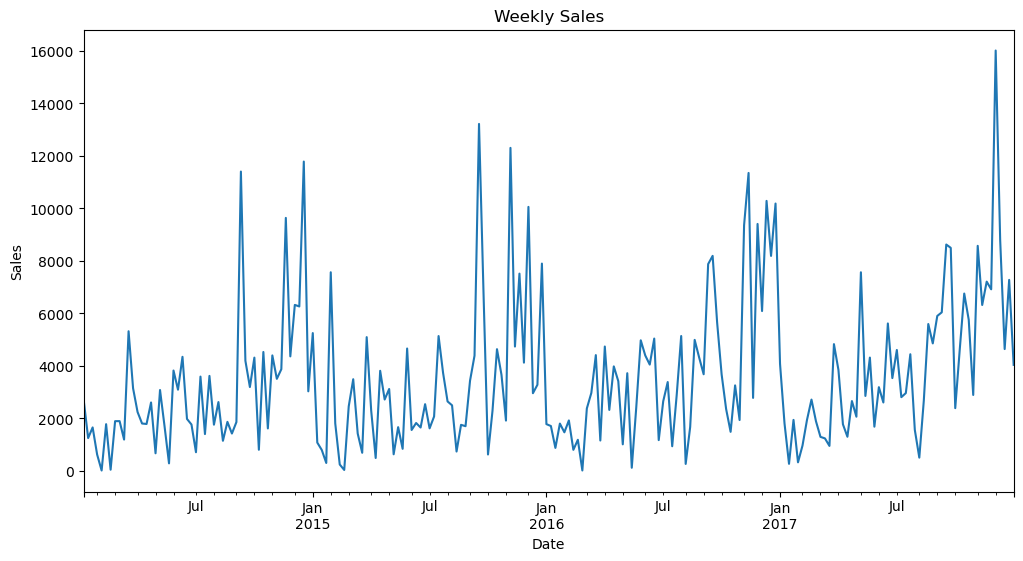

In [39]:
# Resample the data to weekly frequency and sum the sales
df_weekly = df['Sales'].resample('W').sum()

# Ordenar el índice del DataFrame
df_weekly = df_weekly.sort_index()

# Plot the time series
df_weekly.plot(figsize=(12, 6))
plt.title('Weekly Sales')
plt.xlabel('Date')
plt.ylabel('Sales')
plt.show()

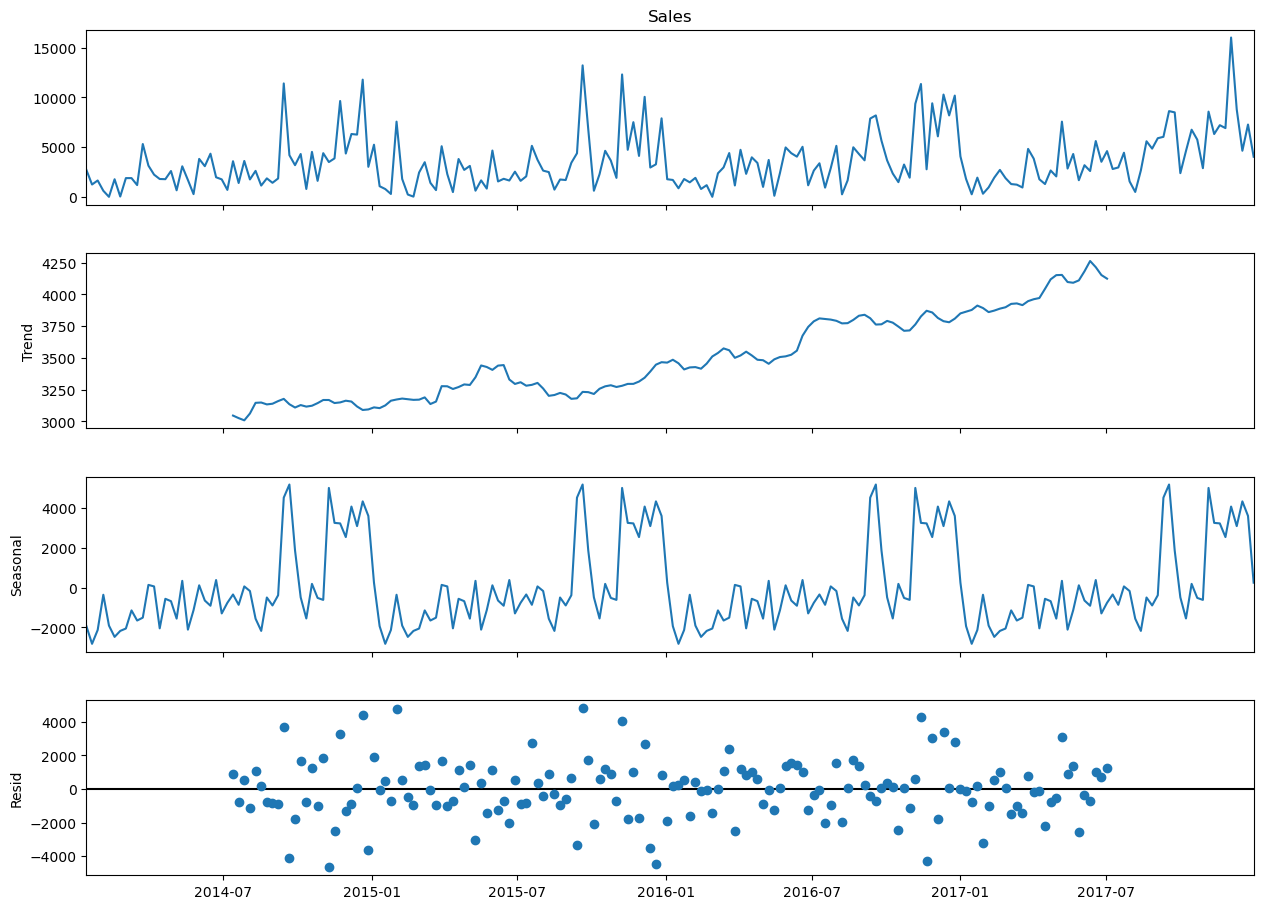

In [40]:

# Decompose the time series
decomposition = seasonal_decompose(df_weekly, model='additive')
fig = decomposition.plot()
fig.set_size_inches(14, 10)
plt.show()

Mensualmente

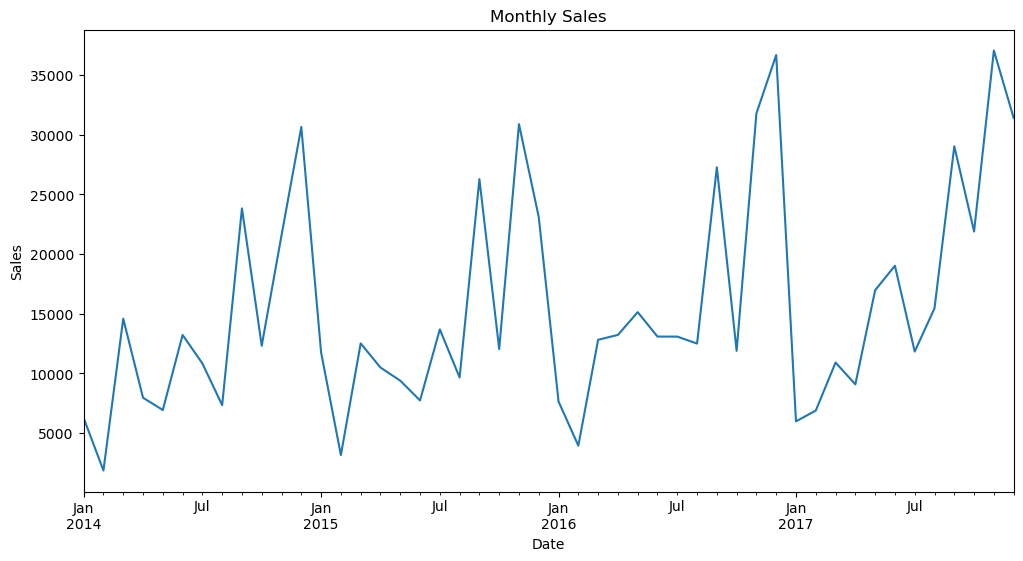

In [41]:

# Resample the data to monthly frequency and sum the sales
df_monthly = df['Sales'].resample('M').sum().copy()

# Ordenar el índice del DataFrame
df_monthly = df_monthly.sort_index()

# Plot the time series
df_monthly.plot(figsize=(12, 6))
plt.title('Monthly Sales')
plt.xlabel('Date')
plt.ylabel('Sales')
plt.show()

count       48.000000
mean     15458.329069
std       9103.800668
min       1839.658000
25%       9297.702400
50%      12650.437500
75%      21644.671575
max      37056.715000
Name: Sales, dtype: float64


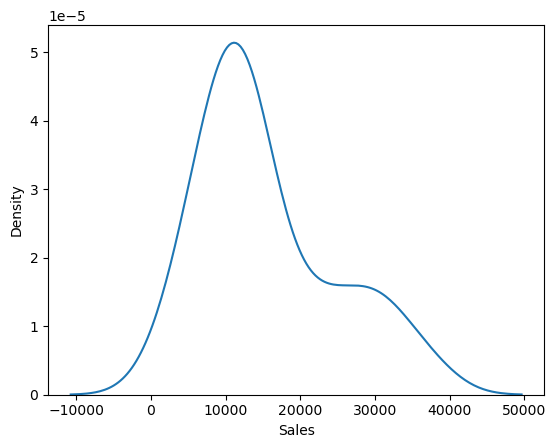

In [42]:
sns.kdeplot(df_monthly)
print(df_monthly.describe()) # Mensual

### Test de Normalidad

In [43]:
# Perform the Shapiro-Wilk test for normality
df_weekly = pd.DataFrame(df_weekly)
stat, p = shapiro(df_weekly['Sales'])
print('Shapiro-Wilk Test: Statistics=%.3f, p=%.3f' % (stat, p))

Shapiro-Wilk Test: Statistics=0.877, p=0.000


- Prueba de Shapiro-Wilk: el valor p < 0,05, lo que indica que los datos de ventas **no se distribuyen normalmente.**

### Normalizacion de la serie temporal

In [44]:
from scipy.stats import boxcox, shapiro

#df_monthly = pd.DataFrame(df_monthly)
df_prepared = df_weekly.copy()
# Aplicar la transformación Box-Cox a los datos de ventas
sales_boxcox, fitted_lambda = boxcox(df_prepared['Sales'] + 1)  # Añadir 1 para evitar valores cero

# Realizar la prueba de Shapiro-Wilk en los datos transformados
stat, p = shapiro(sales_boxcox)
print('Prueba de Shapiro-Wilk después de la transformación Box-Cox:')
print(' Estadística=%.3f, p=%.3f' % (stat, p))
print()
# Verificar si los datos transformados son normalmente distribuidos
if p > 0.05:
    print('Los datos transformados son normalmente distribuidos')
else:
    print('Los datos transformados no son normalmente distribuidos')

# Mostrar las primeras filas de los datos transformados
df_prepared['Sales_BoxCox'] = sales_boxcox
df_prepared.head()

Prueba de Shapiro-Wilk después de la transformación Box-Cox:
 Estadística=0.994, p=0.504

Los datos transformados son normalmente distribuidos


,Sales,Sales_BoxCox
Order Date,,
2014-01-12,2712.428,48.801648
2014-01-19,1250.473,35.861120
2014-01-26,1655.958,40.127575
2014-02-02,623.666,27.039517
2014-02-09,14.560,4.790765


- Prueba de Shapiro-Wilk: el valor p > 0,05, lo que indica que los datos de ventas **se distribuyen normalmente.**

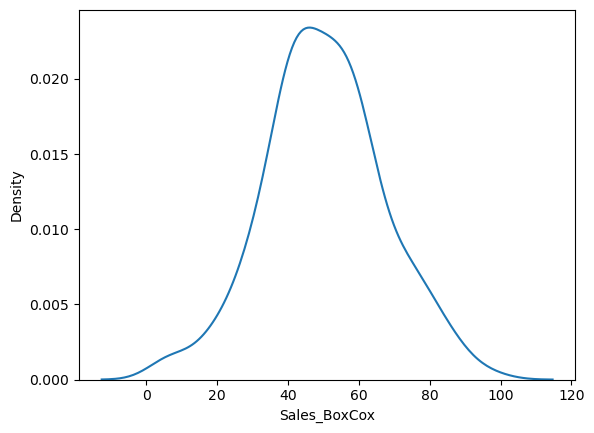

In [45]:
sns.kdeplot(df_prepared['Sales_BoxCox']);

### Descomposicion de la serie temporal

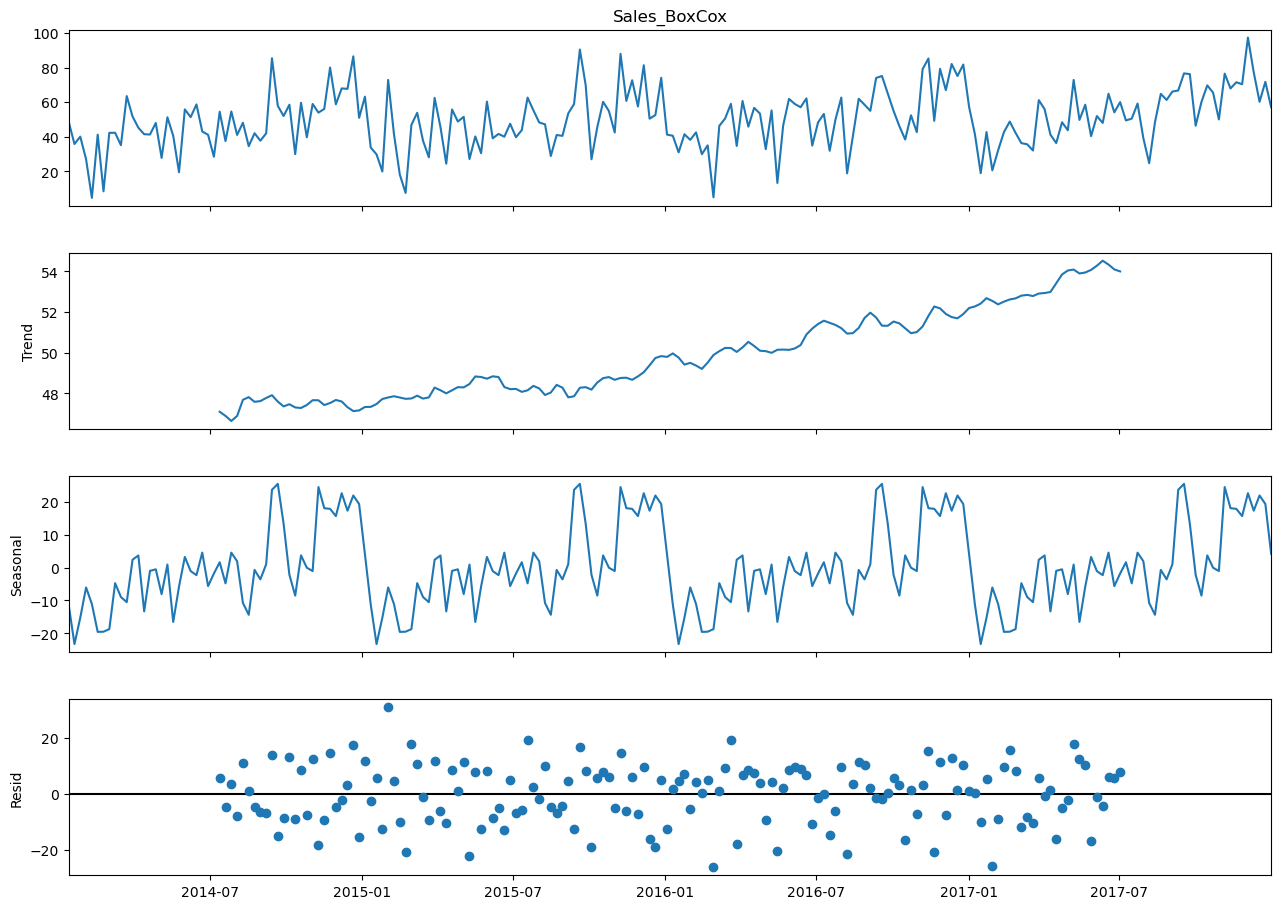

In [46]:
# Decompose the time series
decomposition = seasonal_decompose(df_prepared['Sales_BoxCox'], model='additive')
fig = decomposition.plot()
fig.set_size_inches(14, 10)
plt.show()


La descomposición estacional de la serie temporal revela los siguientes componentes:

- Observado: Los datos de ventas originales.
- Tendencia: El movimiento a largo plazo en los datos presenta tendencia ascendente.
- Estacional: el ciclo repetido a corto plazo en los datos presenta ciclos anuales.

### Test de Dickey-Fuller

In [47]:

# Perform the Augmented Dickey-Fuller test
result = adfuller(df_prepared['Sales_BoxCox'])
print('ADF Statistic: %f' % result[0])
print('p-value: %f' % result[1])
print('Critical Values:')
for key, value in result[4].items():
    print('\	%s: %.3f' % (key, value))

# Check if the series is stationary
if result[1] > 0.05:
    print('Series is non-stationary')
else:
    print('Series is stationary')

ADF Statistic: -6.446043
p-value: 0.000000
Critical Values:
\	1%: -3.462
\	5%: -2.876
\	10%: -2.574
Series is stationary



- Prueba aumentada de Dickey-Fuller: el valor p es inferior a 0,05 y el estadístico ADF es inferior a los valores críticos en los niveles del 1%, 5% y 10%, lo que indica que la serie **es estacionaria**.

### Autocorrelación

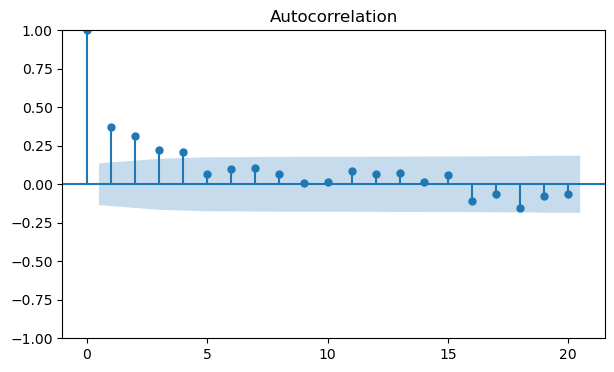

In [51]:
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf
fig, ax = plt.subplots(figsize=(7,4))
plot_acf(df_prepared['Sales_BoxCox'], ax=ax, lags = 20)
plt.show()

### Autocorrelación Parcial

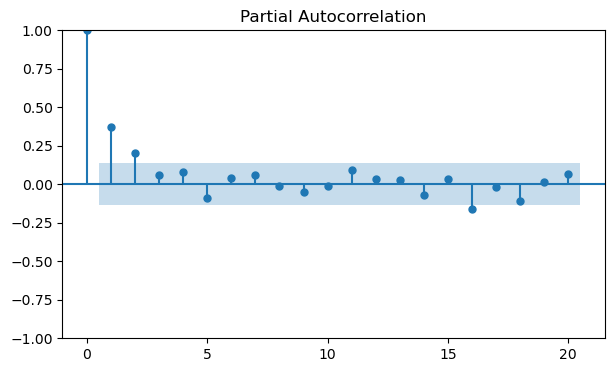

In [52]:

fig, ax = plt.subplots(figsize=(7,4))
plot_pacf(df_prepared['Sales_BoxCox'], ax=ax, lags = 20)
plt.show()

## Dividir los datos en entrenamiento y prueba

In [53]:
# Dividir los datos
df_sales = df_prepared['Sales_BoxCox'].copy()
df_sales = pd.DataFrame(df_sales)

# Conjunto de entrenamiento
df_train = df_sales.iloc[:len(df_sales)-10]

# Conjunto de prueba
df_test = df_sales.iloc[len(df_sales)-10:]

In [54]:
print('Datos de entrenamiento:')
print(df_train.shape)
#print('Datos de prueba:')
print(df_test.shape)

Datos de entrenamiento:
(198, 1)
(10, 1)


## **Modelado**

### ARIMA

In [55]:
import statsmodels.api as sm
from pmdarima import auto_arima

#### Identificar los parámetros del modelo ARIMA

In [295]:
# Identificar los mejores parámetros (p, d, q)
stepwise_fit = auto_arima(df_train['Sales_BoxCox'], seasonal=True, m=52, trace=True)
print(stepwise_fit.summary())

Performing stepwise search to minimize aic
 ARIMA(2,1,2)(1,0,1)[52] intercept   : AIC=inf, Time=10.19 sec
 ARIMA(0,1,0)(0,0,0)[52] intercept   : AIC=1721.579, Time=0.02 sec
 ARIMA(1,1,0)(1,0,0)[52] intercept   : AIC=1677.903, Time=1.74 sec
 ARIMA(0,1,1)(0,0,1)[52] intercept   : AIC=1645.997, Time=1.03 sec
 ARIMA(0,1,0)(0,0,0)[52]             : AIC=1719.583, Time=0.02 sec
 ARIMA(0,1,1)(0,0,0)[52] intercept   : AIC=1651.556, Time=0.05 sec
 ARIMA(0,1,1)(1,0,1)[52] intercept   : AIC=inf, Time=7.10 sec
 ARIMA(0,1,1)(0,0,2)[52] intercept   : AIC=inf, Time=16.81 sec
 ARIMA(0,1,1)(1,0,0)[52] intercept   : AIC=1643.020, Time=2.51 sec
 ARIMA(0,1,1)(2,0,0)[52] intercept   : AIC=inf, Time=13.65 sec
 ARIMA(0,1,1)(2,0,1)[52] intercept   : AIC=inf, Time=23.70 sec
 ARIMA(0,1,0)(1,0,0)[52] intercept   : AIC=1723.566, Time=0.30 sec
 ARIMA(1,1,1)(1,0,0)[52] intercept   : AIC=inf, Time=4.40 sec
 ARIMA(0,1,2)(1,0,0)[52] intercept   : AIC=inf, Time=4.89 sec
 ARIMA(1,1,2)(1,0,0)[52] intercept   : AIC=inf, Ti

In [296]:
print(stepwise_fit.summary())

                                      SARIMAX Results                                      
Dep. Variable:                                   y   No. Observations:                  198
Model:             SARIMAX(0, 1, 1)x(2, 0, [], 52)   Log Likelihood                -813.688
Date:                             Wed, 15 May 2024   AIC                           1635.376
Time:                                     15:17:02   BIC                           1648.509
Sample:                                 01-12-2014   HQIC                          1640.692
                                      - 10-22-2017                                         
Covariance Type:                               opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ma.L1         -0.9756      0.016    -61.962      0.000      -1.006      -0.945
ar.S.L52       0.2842      

#### Entrenamiento

In [301]:
print(stepwise_fit.order)
print(stepwise_fit.seasonal_order)

(0, 1, 1)
(2, 0, 0, 52)


In [56]:
# Ajustar el modelo ARIMA con los parámetros identificados
model = sm.tsa.ARIMA(df_train, order=(0,1,1), seasonal_order= (2,0,0,52))
model_fit = model.fit()
print(model_fit.summary())

                                     SARIMAX Results                                     
Dep. Variable:                      Sales_BoxCox   No. Observations:                  198
Model:             ARIMA(0, 1, 1)x(2, 0, [], 52)   Log Likelihood                -813.688
Date:                           Fri, 17 May 2024   AIC                           1635.376
Time:                                   15:20:36   BIC                           1648.509
Sample:                               01-12-2014   HQIC                          1640.692
                                    - 10-22-2017                                         
Covariance Type:                             opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ma.L1         -0.9756      0.016    -61.962      0.000      -1.006      -0.945
ar.S.L52       0.2842      0.077      3.713

#### Forecasting

In [ ]:
# Predicción en el conjunto de prueba
forecast = model_fit.forecast(steps=10)
df_test['Predicted'] = forecast

#### Evaluación y gráfica del modelo ARIMA

MAE: 6.920152676017624
MSE: 120.03891049217222
RMSE: 10.956227019013992


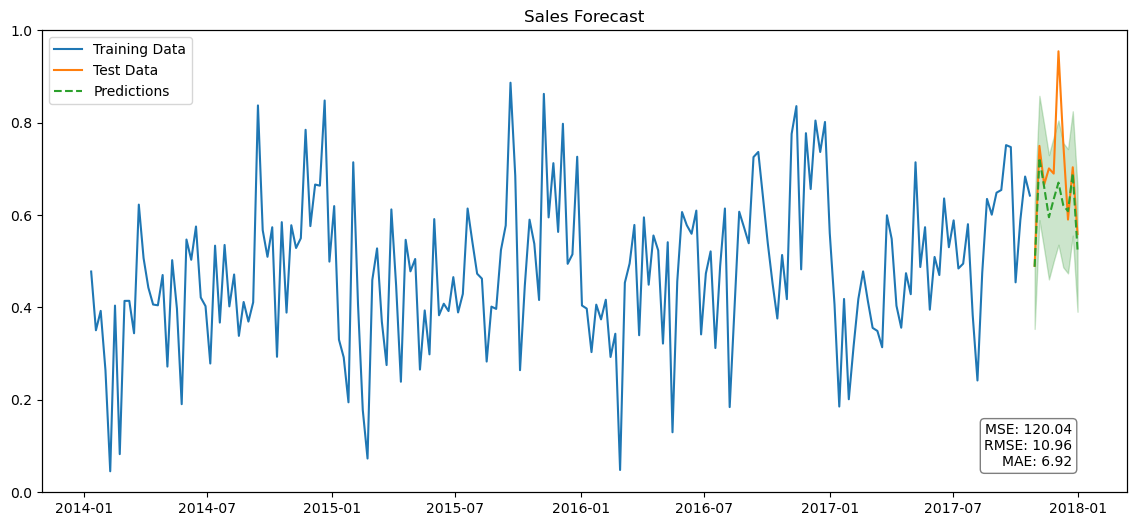

In [124]:
from sklearn.metrics import r2_score

# Evaluar las predicciones
mae = mean_absolute_error(df_test['Sales_BoxCox'], df_test['Predicted'])
mse = mean_squared_error(df_test['Sales_BoxCox'], df_test['Predicted'])
rmse = np.sqrt(mse)

# print(f'MAE: {mae}')
# print(f'MSE: {mse}')
# print(f'RMSE: {rmse}')


# Visualización de los resultados
plt.figure(figsize=(14, 6))


# Calcular y mostrar las métricas
metrics_text = f"MSE: {mse:.2f}\nRMSE: {rmse:.2f}\nMAE: {mae:.2f}"
# Crear un eje secundario para la leyenda de las métricas
ax2 = plt.gca().twinx()
ax2.set_yticks([])
plt.text(0.95, 0.05, metrics_text, 
         transform=ax2.transAxes, 
         fontsize=10, 
         verticalalignment='bottom', 
         horizontalalignment='right', 
         bbox=dict(boxstyle='round', facecolor='white', alpha=0.5))


# Intervalo de confianza
std_error = np.std(df_test['Predicted'])
confidence_interval = 1.96 * std_error
lower_bound = df_test['Predicted'] - confidence_interval
upper_bound = df_test['Predicted'] + confidence_interval
plt.fill_between(df_test.index, lower_bound, upper_bound, alpha=0.2, color='green')


# serie de tiempo
plt.plot(df_train, label='Training Data')
plt.plot(df_test['Sales_BoxCox'], label='Test Data')
plt.plot(df_test['Predicted'], label='Predictions', linestyle='--')
plt.title('Sales Forecast')
plt.legend()
plt.show()


#### Análisis de los residuos

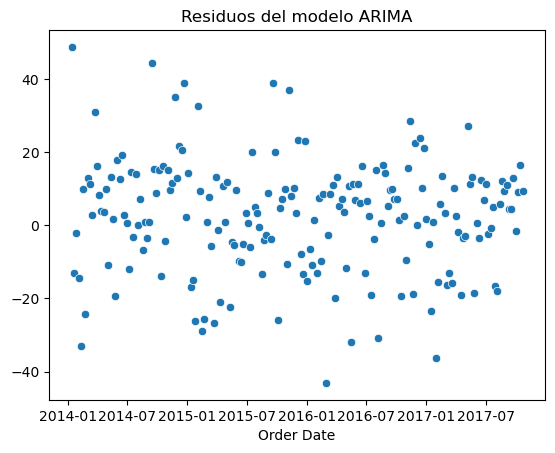

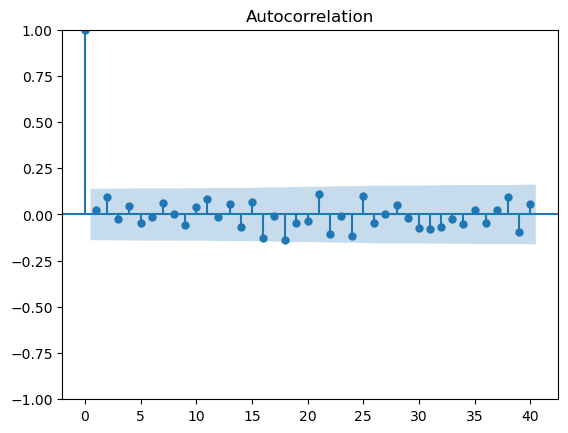

In [65]:
# Graficar los residuos
residuals = model_fit.resid
plt.figure(facecolor='white')
sns.scatterplot(residuals)
plt.title('Residuos del modelo ARIMA')
plt.show()

# Graficar la función de autocorrelación de los residuos
sm.graphics.tsa.plot_acf(residuals, lags=40)
plt.show()

### Random Forest

#### Adaptación de dataset

In [117]:
def create_lag_features(data, lags):
    df = pd.DataFrame(data)
    for lag in range(1, lags + 1):
        df[f'lag_{lag}'] = df['Sales_BoxCox'].shift(lag)
    df = df.dropna()
    return df

lags = 5  # Número de lags
df_lagged = create_lag_features(df_prepared['Sales_BoxCox'], lags)
df_lagged.head()

,Sales_BoxCox,lag_1,lag_2,lag_3,lag_4,lag_5
Order Date,,,,,,
2014-02-16,41.295839,4.790765,27.039517,40.127575,35.861120,48.801648
2014-02-23,8.567038,41.295839,4.790765,27.039517,40.127575,35.861120
2014-03-02,42.332003,8.567038,41.295839,4.790765,27.039517,40.127575
2014-03-09,42.347913,42.332003,8.567038,41.295839,4.790765,27.039517
2014-03-16,35.200363,42.347913,42.332003,8.567038,41.295839,4.790765


In [118]:
df_lagged.shape

(203, 6)

#### Dividir los datos en entrenamiento y Prueba

In [351]:
from sklearn.ensemble import RandomForestRegressor

# Dividir los datos en conjuntos de entrenamiento y prueba
train_size = int(len(df_lagged)-10)#int(len(df_lagged) * 0.9)
train, test = df_lagged.iloc[:train_size], df_lagged.iloc[train_size:]

# Separar características y etiquetas
X_train, y_train = train.drop('Sales_BoxCox', axis=1), train['Sales_BoxCox']
X_test, y_test = test.drop('Sales_BoxCox', axis=1), test['Sales_BoxCox']


#### Entrenamiento

In [373]:
# Ajustar el modelo Random Forest
model = RandomForestRegressor(n_estimators=220, random_state=42)
model.fit(X_train, y_train)


RandomForestRegressor(n_estimators=220, random_state=42)

#### Forecasting

In [374]:
# Realizar predicciones
y_pred = model.predict(X_test)


#### Evaluación

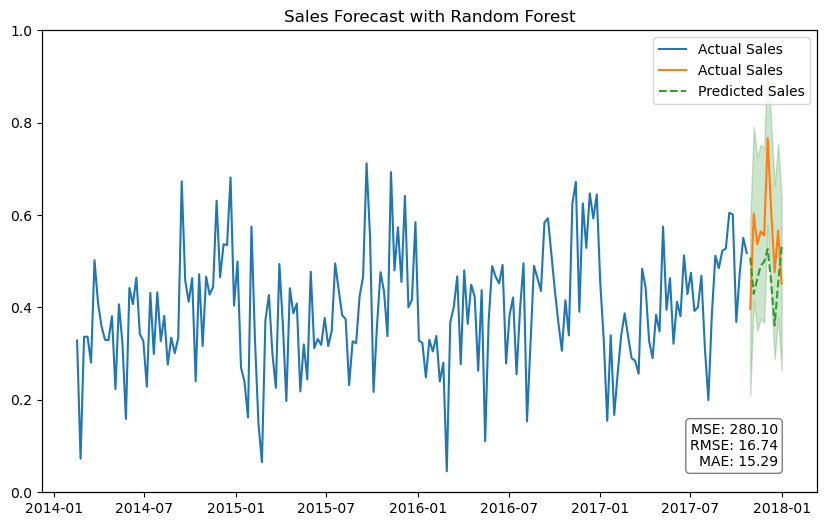

In [375]:

# Evaluar las predicciones
mae = mean_absolute_error(y_test, y_pred)
mse = mean_squared_error(y_test, y_pred)
rmse = np.sqrt(mse)

# Visualización de los resultados
plt.figure(figsize=(10, 6))


# Calcular y mostrar las métricas
metrics_text = f"MSE: {mse:.2f}\nRMSE: {rmse:.2f}\nMAE: {mae:.2f}"
# Crear un eje secundario para la leyenda de las métricas
ax2 = plt.gca().twinx()
ax2.set_yticks([])
plt.text(0.95, 0.05, metrics_text, 
         transform=ax2.transAxes, 
         fontsize=10, 
         verticalalignment='bottom', 
         horizontalalignment='right', 
         bbox=dict(boxstyle='round', facecolor='white', alpha=0.5))


# Intervalo de confianza
std_error = np.std(y_test)
confidence_interval = 1.96 * std_error
lower_bound = y_test- confidence_interval
upper_bound = y_test + confidence_interval
plt.fill_between(y_test.index, lower_bound, upper_bound, alpha=0.2, color='green')



plt.plot(y_train.index, y_train, label='Actual Sales')
plt.plot(y_test.index, y_test, label='Actual Sales')
plt.plot(y_test.index, y_pred, label='Predicted Sales', linestyle='--')
plt.title('Sales Forecast with Random Forest')
plt.legend()
plt.show()

### XGBoost

In [356]:
import xgboost as xgb

# Crear matrices DMatrix para XGBoost
dtrain = xgb.DMatrix(X_train, label=y_train)
dtest = xgb.DMatrix(X_test, label=y_test)

# Configuración de los hiperparámetros
params = {
    'objective': 'reg:squarederror',
    'max_depth': 10,
    'eta': 0.1,
    'subsample': 0.7,
    'colsample_bytree': 0.7
}

# Entrenar el modelo
num_boost_round = 100
model = xgb.train(params, dtrain, num_boost_round)

#### Entrenamiento

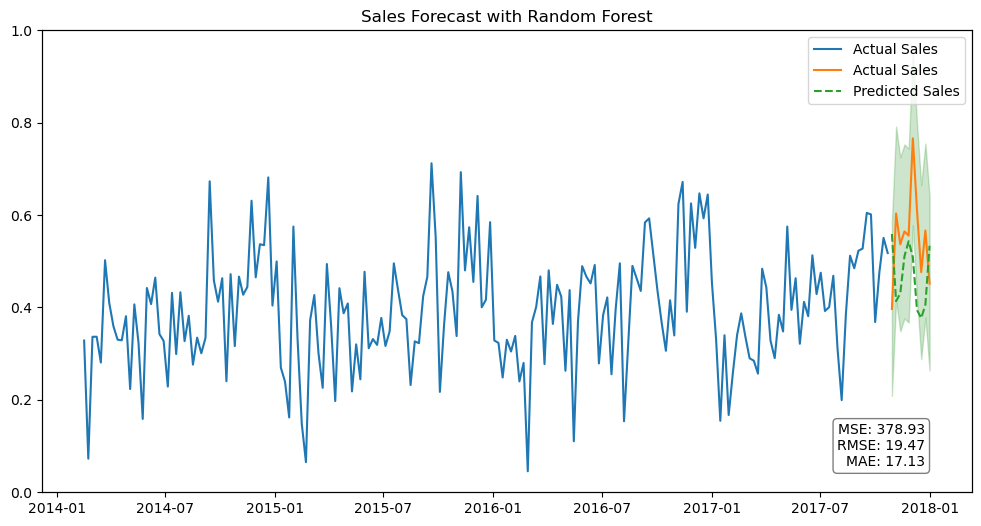

In [357]:
# Realizar predicciones
y_pred = model.predict(dtest)

# Evaluar las predicciones
mae = mean_absolute_error(y_test, y_pred)
mse = mean_squared_error(y_test, y_pred)
rmse = np.sqrt(mse)

# Visualización de los resultados
plt.figure(figsize=(12, 6))


# Calcular y mostrar las métricas
metrics_text = f"MSE: {mse:.2f}\nRMSE: {rmse:.2f}\nMAE: {mae:.2f}"
# Crear un eje secundario para la leyenda de las métricas
ax2 = plt.gca().twinx()
ax2.set_yticks([])
plt.text(0.95, 0.05, metrics_text, 
         transform=ax2.transAxes, 
         fontsize=10, 
         verticalalignment='bottom', 
         horizontalalignment='right', 
         bbox=dict(boxstyle='round', facecolor='white', alpha=0.5))


# Intervalo de confianza
std_error = np.std(y_test)
confidence_interval = 1.96 * std_error
lower_bound = y_test- confidence_interval
upper_bound = y_test + confidence_interval
plt.fill_between(y_test.index, lower_bound, upper_bound, alpha=0.2, color='green')



plt.plot(y_train.index, y_train, label='Actual Sales')
plt.plot(y_test.index, y_test, label='Actual Sales')
plt.plot(y_test.index, y_pred, label='Predicted Sales', linestyle='--')
plt.title('Sales Forecast with Random Forest')
plt.legend()
plt.show()


#### Evaluación

In [354]:
# Evaluar las predicciones en el dominio original
mae = mean_absolute_error(y_test, y_pred)
mse = mean_squared_error(y_test, y_pred)
rmse = np.sqrt(mse)

print(f'MAE: {mae}')
print(f'MSE: {mse}')
print(f'RMSE: {rmse}')

MAE: 16.103483889800334
MSE: 334.0653608536169
RMSE: 18.2774549884172


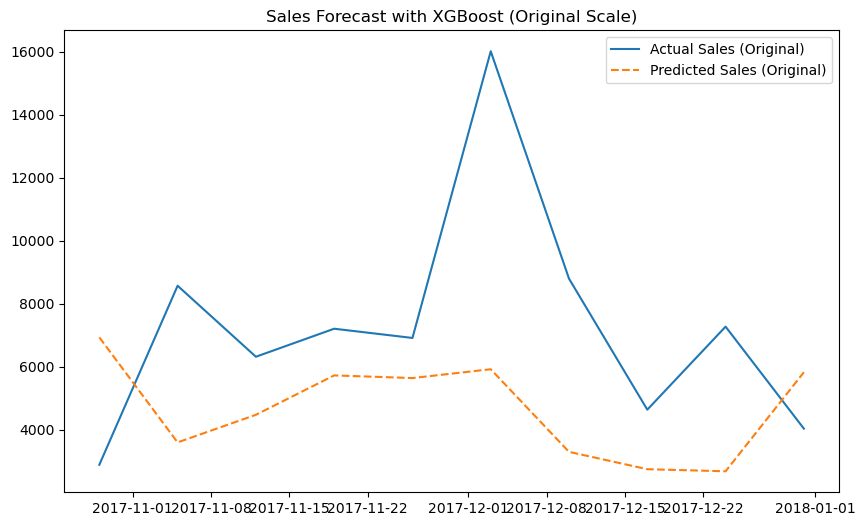

In [355]:
# Inversa de la transformación Box-Cox
y_test_orig = (y_test * fitted_lambda + 1)**(1 / fitted_lambda)
y_pred_orig = (y_pred * fitted_lambda + 1)**(1 / fitted_lambda)


# Visualización de los resultados originales
plt.figure(figsize=(10, 6))
plt.plot(y_test.index, y_test_orig, label='Actual Sales (Original)')
plt.plot(y_test.index, y_pred_orig, label='Predicted Sales (Original)', linestyle='--')
plt.title('Sales Forecast with XGBoost (Original Scale)')
plt.legend()
plt.show()


### LSTM Bidireccional 

In [150]:
import numpy as np
import pandas as pd
from sklearn.preprocessing import StandardScaler, MinMaxScaler
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import LSTM, Dense, Dropout
from keras.callbacks import EarlyStopping
from sklearn.metrics import mean_squared_error
import matplotlib.pyplot as plt
from scipy.stats import norm

#### Preparación y división de datos

In [377]:
# Suponiendo que df_prepared es tu DataFrame y 'Sales_BoxCox' es la columna objetivo
df_sales = df_prepared['Sales_BoxCox'].copy()
df_sales = pd.DataFrame(df_sales)

# Escalar los datos
scaler = StandardScaler()#MinMaxScaler(feature_range=(0, 1))
df_sales_scaled = scaler.fit_transform(df_sales)

# Crear ventanas de tiempo
def create_dataset(dataset, time_window=1):
    dataX, dataY = [], []
    for i in range(len(dataset)-time_window-1):
        a = dataset[i:(i+time_window), 0]
        dataX.append(a)
        dataY.append(dataset[i + time_window, 0])
    return np.array(dataX), np.array(dataY)

time_window = 3  # Por ejemplo, usar 3 periodos anteriores para predecir el siguiente
X, y = create_dataset(df_sales_scaled, time_window)

# Dividir los datos en conjuntos de entrenamiento y prueba
train_size = int(len(X) * 0.8)
test_size = len(X) - train_size
X_train, X_test = X[0:train_size], X[train_size:len(X)]
y_train, y_test = y[0:train_size], y[train_size:len(y)]

# Redimensionar los datos para cumplir con la entrada de LSTM [muestras, pasos de tiempo, características]
X_train = np.reshape(X_train, (X_train.shape[0], time_window, 1))
X_test = np.reshape(X_test, (X_test.shape[0], time_window, 1))

#### Construcción y entrenamiento del modelo

In [397]:
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import LSTM, Dense, Dropout, Bidirectional
from keras.callbacks import EarlyStopping

# Definir el tamaño de la ventana temporal
time_window = 4 

# Construir el modelo LSTM bidireccional
model = Sequential()
model.add(Bidirectional(LSTM(700, activation='relu', return_sequences=True), input_shape=(time_window, 1)))
model.add(Dropout(0.2))
model.add(Bidirectional(LSTM(100, activation='relu')))
model.add(Dropout(0.05))
model.add(Dense(1))
model.compile(optimizer='adam', loss='mse')

# Entrenar el modelo
early_stop = EarlyStopping(monitor='val_loss', patience=10)
hist = model.fit(X_train, y_train, epochs=100, batch_size=2, verbose=1, 
                 validation_data=(X_test, y_test), callbacks=[early_stop])


Epoch 1/100
82/82 ━━━━━━━━━━━━━━━━━━━━ 24s 96ms/step - loss: 0.9791 - val_loss: 0.6717
Epoch 2/100
82/82 ━━━━━━━━━━━━━━━━━━━━ 6s 73ms/step - loss: 0.7663 - val_loss: 0.6890
Epoch 3/100
82/82 ━━━━━━━━━━━━━━━━━━━━ 6s 73ms/step - loss: 0.7623 - val_loss: 0.7285
Epoch 4/100
82/82 ━━━━━━━━━━━━━━━━━━━━ 6s 74ms/step - loss: 0.9023 - val_loss: 0.7769
Epoch 5/100
82/82 ━━━━━━━━━━━━━━━━━━━━ 6s 72ms/step - loss: 0.8967 - val_loss: 0.6541
Epoch 6/100
82/82 ━━━━━━━━━━━━━━━━━━━━ 6s 72ms/step - loss: 0.9265 - val_loss: 0.7255
Epoch 7/100
82/82 ━━━━━━━━━━━━━━━━━━━━ 6s 73ms/step - loss: 0.8593 - val_loss: 0.7329
Epoch 8/100
82/82 ━━━━━━━━━━━━━━━━━━━━ 6s 73ms/step - loss: 0.9441 - val_loss: 0.6598
Epoch 9/100
82/82 ━━━━━━━━━━━━━━━━━━━━ 6s 73ms/step - loss: 0.7276 - val_loss: 0.7997
Epoch 10/100
82/82 ━━━━━━━━━━━━━━━━━━━━ 6s 73ms/step - loss: 0.7990 - val_loss: 0.6132
Epoch 11/100
82/82 ━━━━━━━━━━━━━━━━━━━━ 6s 72ms/step - loss: 0.8359 - val_loss: 0.7119
Epoch 12/100
82/82 ━━━━━━━━━━━━━━━━━━━━ 6s 72ms/ste

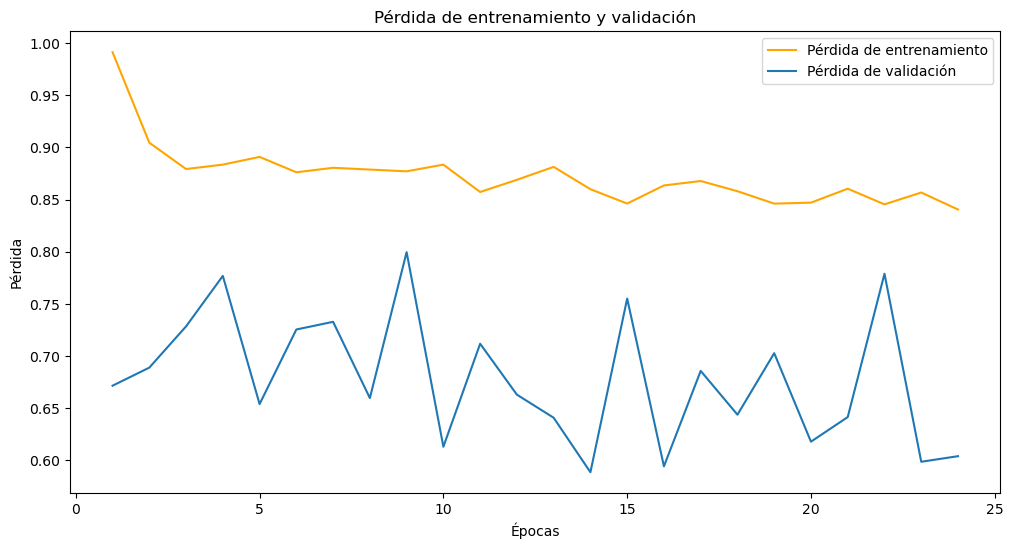

In [398]:
# Extraer la pérdida de entrenamiento y validación
loss = hist.history['loss']
val_loss = hist.history['val_loss']

# Crear conteo de número de épocas
epochs = range(1, len(loss) + 1)

# Graficar la pérdida de entrenamiento y validación
plt.figure(figsize=(12, 6))
plt.plot(epochs, loss, '-', label='Pérdida de entrenamiento', color='orange')  # 'bo' indica "blue dot"
plt.plot(epochs, val_loss, '-', label='Pérdida de validación')  # 'b' indica "solid blue line"
plt.title('Pérdida de entrenamiento y validación')
plt.xlabel('Épocas')
plt.ylabel('Pérdida')
plt.legend()

plt.show()


#### Forecasting

In [399]:
y_train_predict = model.predict(X_train)
y_test_predict = model.predict(X_test)

6/6 ━━━━━━━━━━━━━━━━━━━━ 4s 366ms/step
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 15ms/step


#### Evaluación

In [400]:
# invertir 
# datos reales
y_train_inv = scaler.inverse_transform([y_train])
y_test_inv = scaler.inverse_transform([y_test])
# datos predichos
train_pred_inv = scaler.inverse_transform(y_train_predict)
y_pred_inv = scaler.inverse_transform(y_test_predict)


# Evaluar las predicciones en el dominio original
train_score = np.sqrt(mean_squared_error(y_train_inv[0], train_pred_inv[:,0]))
print(f'Train Score: {train_score:.3f} RMSE')
test_score = np.sqrt(mean_squared_error(y_test_inv[0], y_pred_inv[:,0]))
print(f'Test Score: {test_score:.3f} RMSE')
mae = mean_absolute_error(y_train_inv[0], train_pred_inv[:,0])
print(f'Test Score: {mae:.3f} MAE')

Train Score: 15.195 RMSE
Test Score: 13.048 RMSE
Test Score: 11.747 MAE


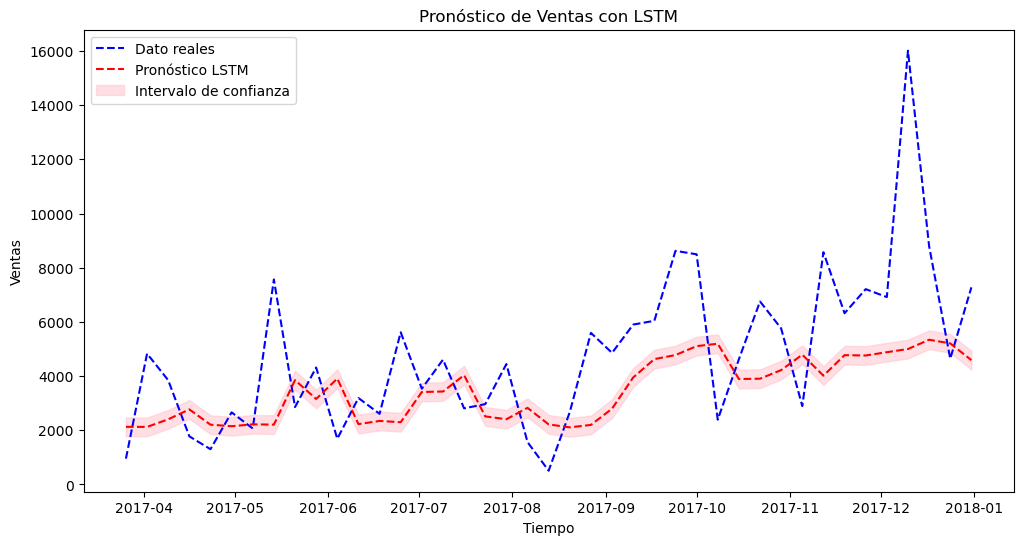

In [401]:
y_test_inv_reshape = y_test_inv.flatten().reshape(-1,1)

# Inversa de la transformación Box-Cox
y_test_orig = (y_test_inv_reshape * fitted_lambda + 1)**(1 / fitted_lambda)
y_pred_orig = (y_pred_inv * fitted_lambda + 1)**(1 / fitted_lambda)


# Calcular el intervalo de confianza sobre los datos reescalados
intervalo_confianza = 1.96 * np.std(y_pred_orig) / np.sqrt(len(y_pred_orig))
lower_bound = y_pred_orig - intervalo_confianza
upper_bound = y_pred_orig + intervalo_confianza

# Crear un índice de tiempo para el eje x
time_index = range(len(y_test_orig))

# Graficar los resultados
plt.figure(figsize=(12, 6))
#plt.plot(time_index, y_test_rescaled, label='Datos Reales', color='blue')
plt.plot(df_sales.index[-len(y_test_orig):], y_test_orig, label='Dato reales', color='blue', linestyle='--')
plt.plot(df_sales.index[-len(y_pred_orig):], y_pred_orig, label='Pronóstico LSTM', color='red', linestyle='--')
plt.fill_between(df_sales.index[-len(y_pred_orig):], lower_bound.flatten(), upper_bound.flatten(), color='pink', alpha=0.5, label='Intervalo de confianza')

# Títulos y etiquetas
plt.title('Pronóstico de Ventas con LSTM')
plt.xlabel('Tiempo')
plt.ylabel('Ventas')
plt.legend()
plt.show()
